In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-iot/test_ML_IOT.csv
/kaggle/input/ml-iot/sample_submission_ML_IOT.csv
/kaggle/input/ml-iot/train_ML_IOT.csv


**Importing necessary packages**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import polars as pl
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error

# Loading Data

Let's disover our data by printing and get some infos like the head(), Describe() and Stuff which are necessary to understand in depth our data

In [3]:
data = pd.read_csv("../input/ml-iot/train_ML_IOT.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
del data['ID']

In [5]:
data

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9
...,...,...,...
48115,2017-06-30 19:00:00,4,11
48116,2017-06-30 20:00:00,4,30
48117,2017-06-30 21:00:00,4,16
48118,2017-06-30 22:00:00,4,22


In [6]:
data.describe()

,Junction,Vehicles
count,48120.000000,48120.000000
mean,2.180549,22.791334
std,0.966955,20.750063
min,1.000000,1.000000
25%,1.000000,9.000000
50%,2.000000,15.000000
75%,3.000000,29.000000
max,4.000000,180.000000


In [7]:
data.sample(10)

,DateTime,Junction,Vehicles
1503,2016-01-02 15:00:00,1,16
25490,2017-01-28 02:00:00,2,14
45927,2017-03-31 15:00:00,4,8
8099,2016-10-03 11:00:00,1,65
22829,2016-10-09 05:00:00,2,7
45844,2017-03-28 04:00:00,4,7
28087,2017-05-16 07:00:00,2,19
25805,2017-02-10 05:00:00,2,12
7869,2016-09-23 21:00:00,1,69
19078,2016-05-05 22:00:00,2,15


**Exploratory Data Analysis**

In [8]:
train = data.copy() 
colors = ["#711DB0", "#8ACDD7", "#EF4040", "#65B741"]

Let's visualize our data to see how it looks

Text(0.5, 0, 'Date')

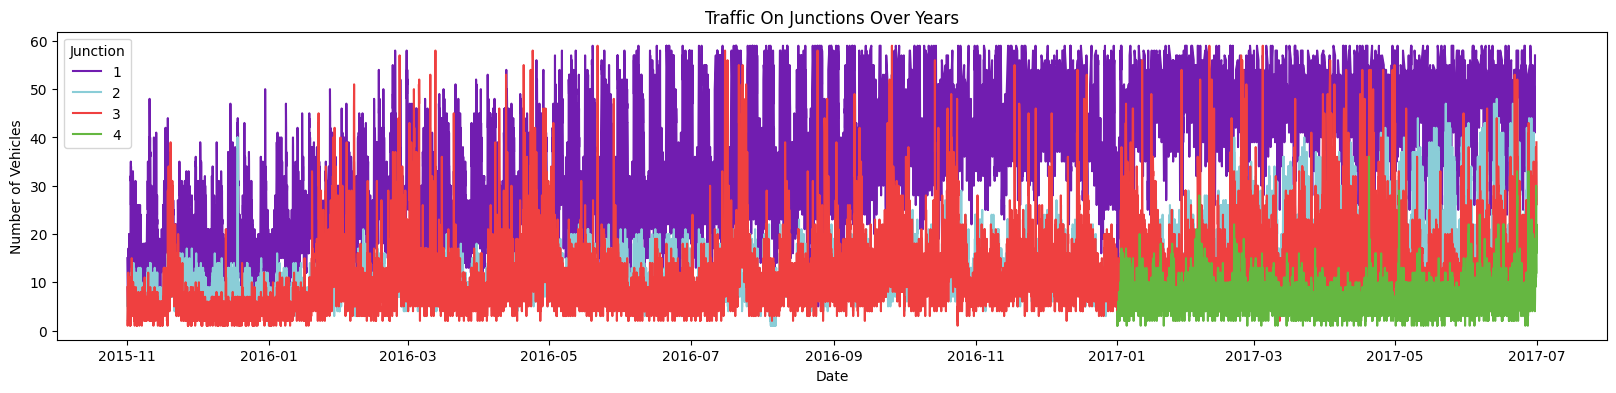

In [90]:
plt.figure(figsize=(20,4))
Time_series=sns.lineplot(x=train['DateTime'], y="Vehicles", data=train, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

The plot is too bad and trying to understand this looks more complicated so lets try to create or extract new features from data to have a good visibility otherwise these features can help capture temporal patterns in the data, finally build a good model 

In [9]:
train['DateTime'] = pd.to_datetime(train['DateTime'])

# Extract some features for the data columns
train['Year'] = train['DateTime'].dt.year
train['Month'] = train['DateTime'].dt.month
train['Day'] = train['DateTime'].dt.day
train['Dayofweek'] = train['DateTime'].dt.dayofweek
train['DayOfyear'] = train['DateTime'].dt.dayofyear
train["Hour"]= train['DateTime'].dt.hour
train["Quarter"]= train['DateTime'].dt.quarter
train['Weekday'] = train['DateTime'].dt.weekday < 5
train['Weekend'] = ~train['Weekday']


In [10]:
train

,DateTime,Junction,Vehicles,Year,Month,Day,Dayofweek,DayOfyear,Hour,Quarter,Weekday,Weekend
0,2015-11-01 00:00:00,1,15,2015,11,1,6,305,0,4,False,True
1,2015-11-01 01:00:00,1,13,2015,11,1,6,305,1,4,False,True
2,2015-11-01 02:00:00,1,10,2015,11,1,6,305,2,4,False,True
3,2015-11-01 03:00:00,1,7,2015,11,1,6,305,3,4,False,True
4,2015-11-01 04:00:00,1,9,2015,11,1,6,305,4,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,2017,6,30,4,181,19,2,True,False
48116,2017-06-30 20:00:00,4,30,2017,6,30,4,181,20,2,True,False
48117,2017-06-30 21:00:00,4,16,2017,6,30,4,181,21,2,True,False
48118,2017-06-30 22:00:00,4,22,2017,6,30,4,181,22,2,True,False


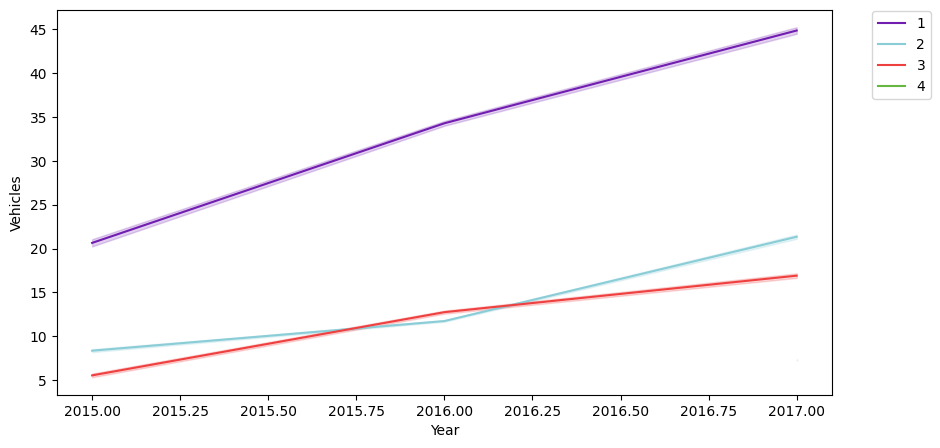

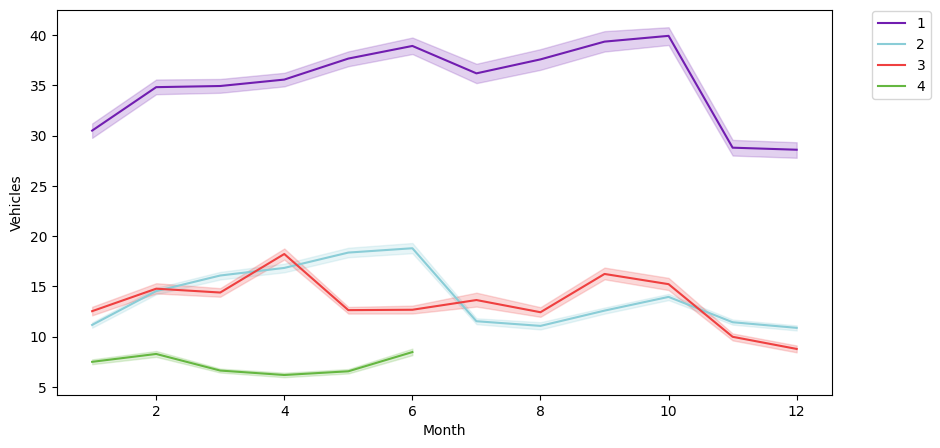

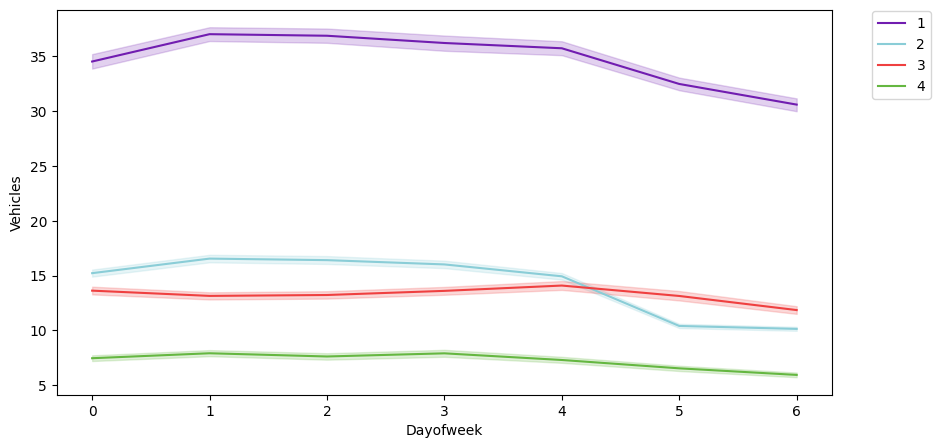

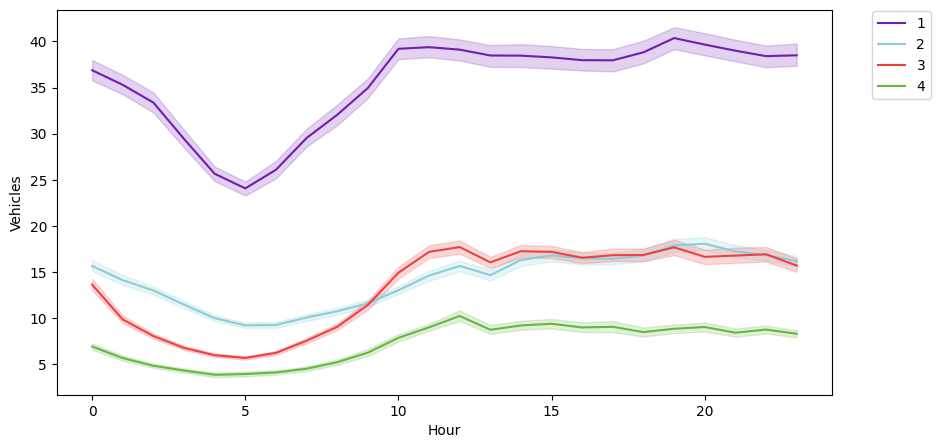

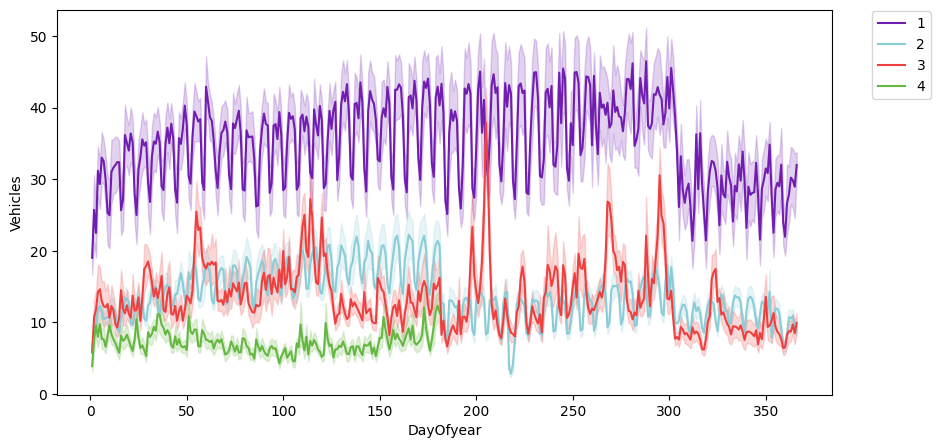

In [93]:
new_features = [ "Year","Month", "Dayofweek", "Hour", "DayOfyear"]  # Plotting new feature

for i in new_features:
    plt.figure(figsize=(10,5))
    ax=sns.lineplot(x=train[i], y="Vehicles", data=train, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

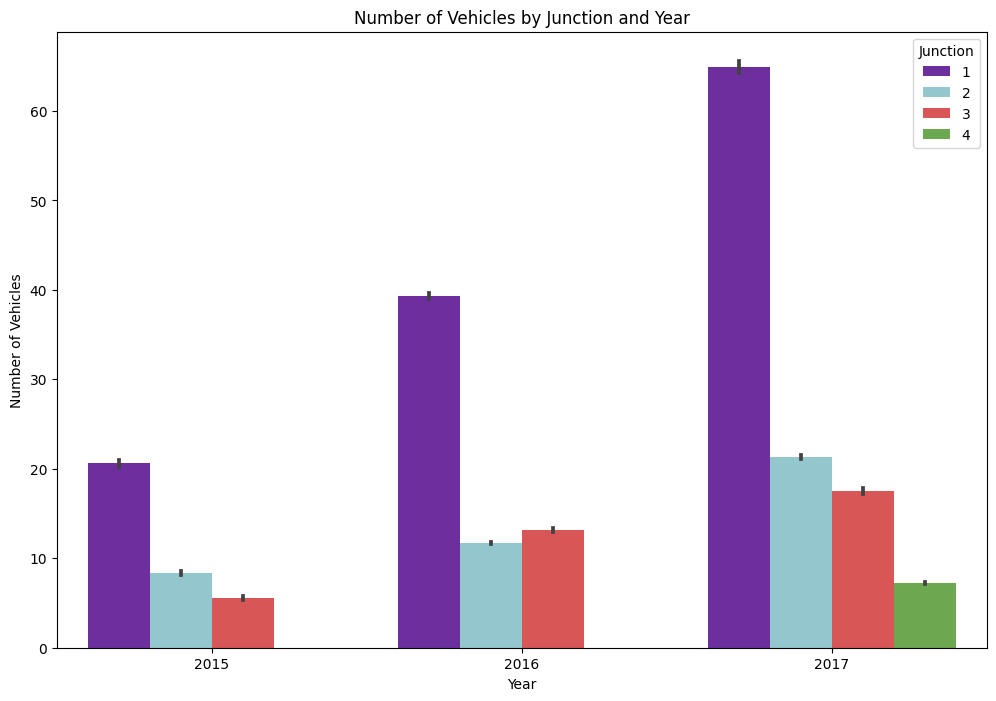

In [11]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Year', y='Vehicles', hue='Junction', data=train, palette=colors)
plt.title('Number of Vehicles by Junction and Year')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles')
plt.show()

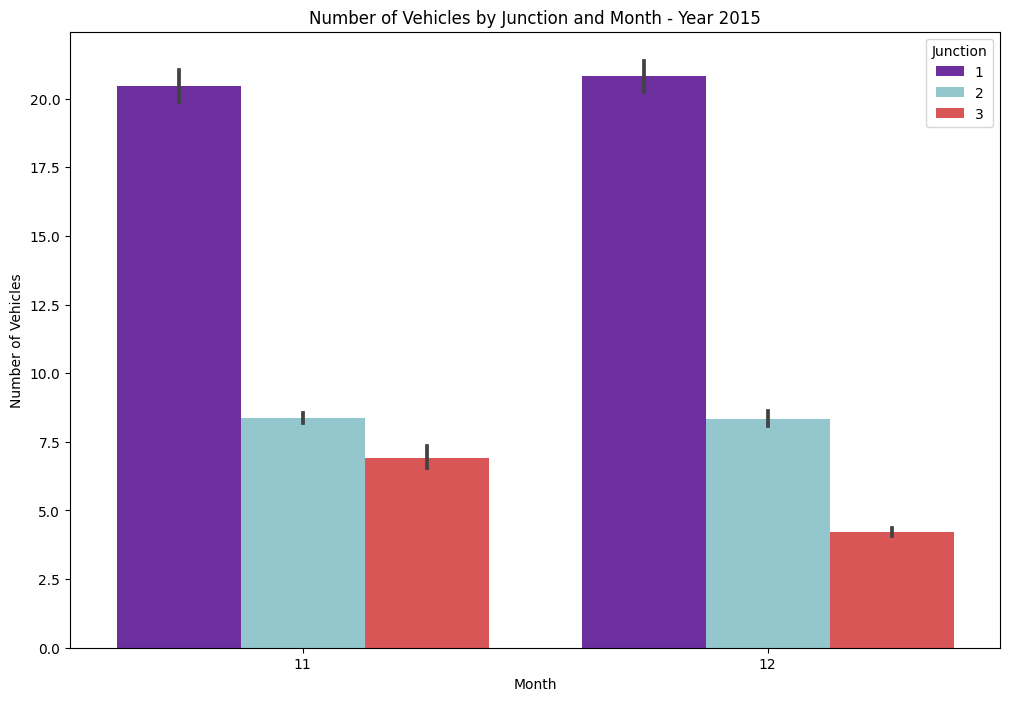

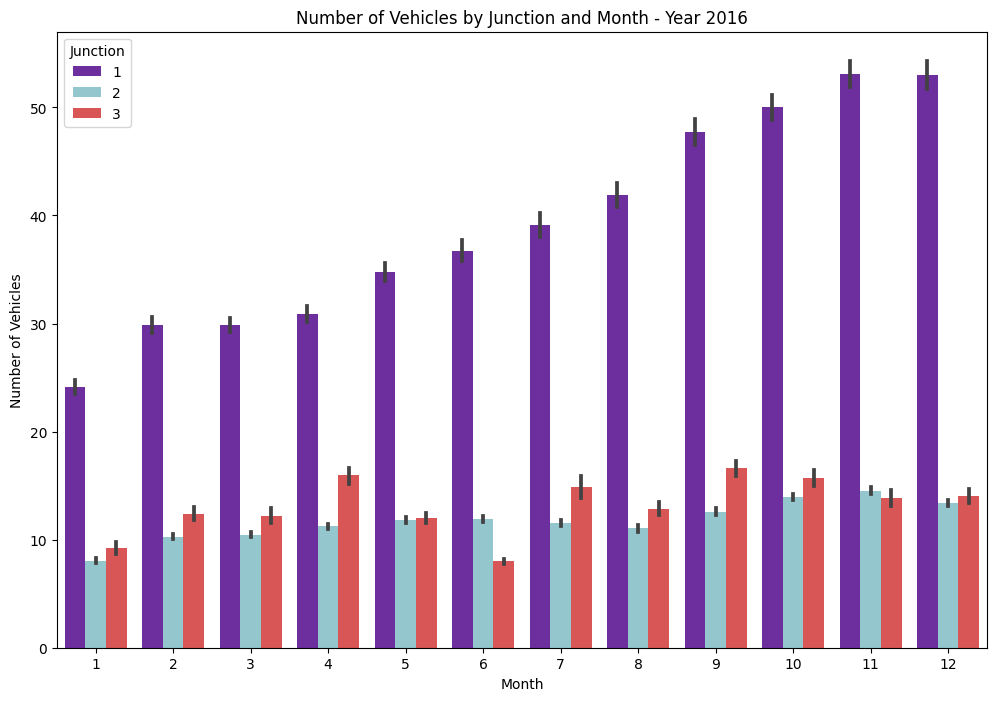

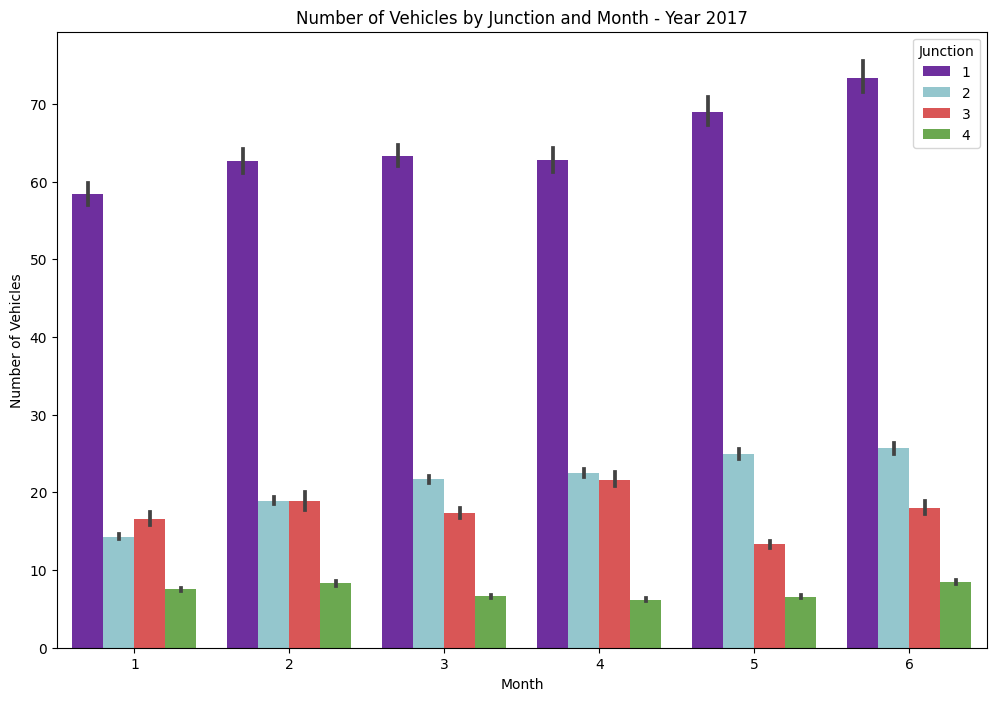

In [12]:
years = train['Year'].unique()

for year in years:
    # Filter data for the current year
    data_year = train[train['Year'] == year]
    
    # Plot for the current year
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Month', y='Vehicles', hue='Junction', data=data_year, palette=colors)
    plt.title(f'Number of Vehicles by Junction and Month - Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Number of Vehicles')
    plt.show()

the data presented by EDA is a little ambiguous we think that junctions should be transformed as per

# Preprocessing of DATA

We're going to filtre data from missing values and outliers

In [13]:
missing_values = train.isnull().sum()
missing_values

DateTime     0
Junction     0
Vehicles     0
Year         0
Month        0
Day          0
Dayofweek    0
DayOfyear    0
Hour         0
Quarter      0
Weekday      0
Weekend      0
dtype: int64

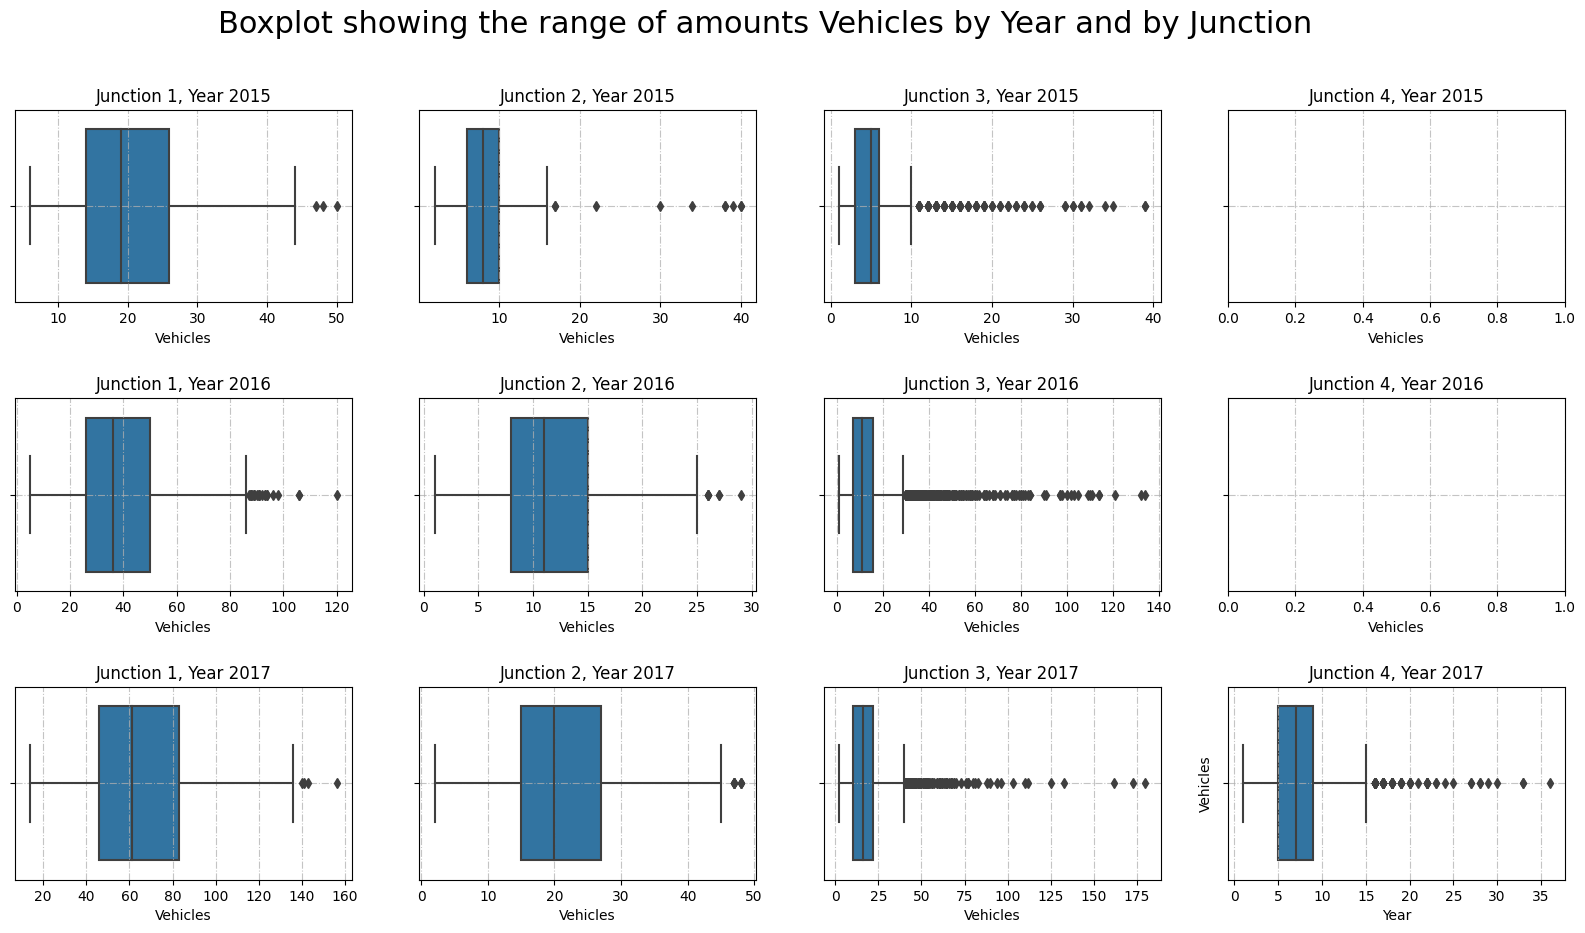

In [14]:
f, axis = plt.subplots(3, 4, figsize=(20, 10))

for i, year in zip(range(3), range(2015, 2018)):
  for j, junction in zip(range(4), range(1, 5)):
    sns.boxplot(x=train[(train["Junction"] == junction) & (train["Year"] == year)]['Vehicles'], ax=axis[i, j])
    axis[i, j].grid(True, alpha=0.75, ls='-.')


junction_names = ['Junction 1', 'Junction 2', 'Junction 3', 'Junction 4']
year = 2015
for i in range(3):
  for j in range(4):
    axis[i, j].set_title(f'{junction_names[j]}, Year {year + i}')


plt.subplots_adjust(hspace=0.5)  # Add this line to increase the space between subplots

plt.xlabel('Year')
plt.ylabel('Vehicles')
f.suptitle('Boxplot showing the range of amounts Vehicles by Year and by Junction', fontsize=22)
plt.show()

In each subplot, a boxplot is plotted visualizing the distribution of the "Vehicles" variable for a particular year and intersection combination 

As we see there's a lot of outliers in our trainset so we're going to filtre it using IQR methods 

In [15]:
# Filter outliers based on interquartile range (IQR)
Q1 = train['Vehicles'].quantile(0.25)
Q3 = train['Vehicles'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train = train[(train['Vehicles'] >= lower_bound) & (train['Vehicles'] <= upper_bound)]

In [16]:
print("Size of original data:", len(data), "Size after filtering outliers:", len(train))

Size of original data: 48120 Size after filtering outliers: 44503


Now we're going split junctions and prepare each junction itself by doing this we'll have a boost to get a good prediction

In [17]:
df_junctions = data.pivot(columns="Junction", index="DateTime")  # Junction 1,2,3,4 columns
df_junctions

Vehicles                  
Junction                   1     2     3     4
DateTime                                      
2015-11-01 00:00:00     15.0   6.0   9.0   NaN
2015-11-01 01:00:00     13.0   6.0   7.0   NaN
2015-11-01 02:00:00     10.0   5.0   5.0   NaN
2015-11-01 03:00:00      7.0   6.0   1.0   NaN
2015-11-01 04:00:00      9.0   7.0   2.0   NaN
...                      ...   ...   ...   ...
2017-06-30 19:00:00    105.0  34.0  33.0  11.0
2017-06-30 20:00:00     96.0  35.0  31.0  30.0
2017-06-30 21:00:00     90.0  31.0  28.0  16.0
2017-06-30 22:00:00     84.0  29.0  26.0  22.0
2017-06-30 23:00:00     78.0  27.0  39.0  12.0

[14592 rows x 4 columns]

In [47]:
# we created a new dataframe for each junction.
df_junction_1 = df_junctions[[('Vehicles', 1)]] 
df_junction_2 = df_junctions[[('Vehicles', 2)]]
df_junction_3 = df_junctions[[('Vehicles', 3)]]
df_junction_4 = df_junctions[[('Vehicles', 4)]]
df_junction_4 = df_junction_4.dropna() # we dropped null values because there was limited data on Junction 4 

list_df_junctions = [df_junction_1, df_junction_2, df_junction_3, df_junction_4]
for i in list_df_junctions:  # we removed the column labels of a multi-level dataframe.
    i.columns= i.columns.droplevel(level=1)

In [48]:
df_junction_1.Vehicles

DateTime
2015-11-01 00:00:00     15.0
2015-11-01 01:00:00     13.0
2015-11-01 02:00:00     10.0
2015-11-01 03:00:00      7.0
2015-11-01 04:00:00      9.0
                       ...  
2017-06-30 19:00:00    105.0
2017-06-30 20:00:00     96.0
2017-06-30 21:00:00     90.0
2017-06-30 22:00:00     84.0
2017-06-30 23:00:00     78.0
Name: Vehicles, Length: 14592, dtype: float64

# Normalizing Data 

Steps for Transforming: Normalizing - Differencing

The Normalize function is used to standardize the data, while the Difference function is used to make the time series stationary or to extract seasonality patterns.

In [56]:
def preprocess_junction(df_junction, col, interval):
    df_normalized, average, stdev = normalize(df_junction, col)
    diff = difference(df_normalized, col, interval)
    
    df_normalized = df_normalized[interval:]
    df_junction = df_junction[interval:]
    
    df_normalized.columns = ["Norm"]
    df_normalized["Diff"] = diff
    
    return df_normalized, df_junction, average, stdev

Differencing to eliminate the seasonality should be performed as follows:

For Junction one, we will be taking a difference of weekly values. For junction two, The difference of consecutive days is a better choice For Junctions three and four, the difference of the hourly values will serve the purpose.

In [57]:
#Normalizing and Differencing to make the series stationary 

df_normalized_1, df_junction_1, av_J1, std_J1 = preprocess_junction(df_junction_1, "Vehicles", 24*7) 
df_normalized_2, df_junction_2, av_J2, std_J2 = preprocess_junction(df_junction_2, "Vehicles", 24)   
df_normalized_3, df_junction_3, av_J3, std_J3 = preprocess_junction(df_junction_3, "Vehicles", 1)  
df_normalized_4, df_junction_4, av_J4, std_J4 = preprocess_junction(df_junction_4, "Vehicles", 1)

df_normalized_2

,Norm,Diff
DateTime,,
2015-11-05 00:00:00,-0.849238,-0.270190
2015-11-05 01:00:00,-0.984333,-0.135095
2015-11-05 02:00:00,-0.849238,0.135095
2015-11-05 03:00:00,-1.254523,-0.270190
2015-11-05 04:00:00,-1.389618,-0.135095
...,...,...
2017-06-30 19:00:00,2.663233,-0.945665
2017-06-30 20:00:00,2.798328,-0.675475
2017-06-30 21:00:00,2.257948,-0.270190


In [58]:
def check_stationary(df_all_junctions):
    check = adfuller(df_all_junctions.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  
#Checking if the series is stationary

list_df_normalized = [ df_normalized_1["Diff"], df_normalized_2["Diff"], df_normalized_3["Diff"], df_normalized_4["Diff"]] 
for i in list_df_normalized:
    print("\n")
    check_stationary(i)



ADF Statistic: -14.829213864607457
p-value: 1.910691895949583e-27
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.727605812063732
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -27.999288566161923
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.966498293868465
p-value: 2.8052247185442255e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


The ADF test is used to test the stationarity of the time series. The test results show that the p-value is lower than a certain threshold value (usually 0.05) and the ADF statistic is lower compared to the critical values. Therefore, we can conclude that the time series is stationary and contains no obvious trends or structures over time. This means that the time series becomes more suitable for statistical analysis and forecasting.

Now data is stationary, preprocessing the data for the neural net by:

Splitting the test train sets Assigning X as features and y as target Reshaping data for neural net











So as we know when differencing a time series, especially with a lag of one (interval=1), the first observation in the differenced series becomes a missing value (NaN) because there is no previous value to difference it with so we're going to treate this issue by keep a copy of the original data before differencing. Then, for each junction, it takes the differenced series, drops the NaN values, and converts the resulting Series to a DataFrame.

In [60]:
#Differencing created some NA values as we took a weeks data into consideration while differencing
df_junction_1_not_normalized = df_junction_1.copy()
df_junction_1 = df_normalized_1["Diff"].dropna()  #dropping null values
df_junction_1 = df_junction_1.to_frame()

df_junction_2_not_normalized = df_junction_2.copy()
df_junction_2 = df_normalized_2["Diff"].dropna()
df_junction_2 = df_junction_2.to_frame()

df_junction_3_not_normalized = df_junction_3.copy()
df_junction_3 = df_normalized_3["Diff"].dropna()
df_junction_3 = df_junction_3.to_frame()

df_junction_4_not_normalized = df_junction_4.copy()
df_junction_4 = df_normalized_4["Diff"].dropna()
df_junction_4 = df_junction_4.to_frame()

# Test And Split

In [62]:
def split_data(df):
    training_size = int(len(df)*0.80)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test


junction_1_train, junction_1_test = split_data(df_junction_1)
junction_2_train, junction_2_test = split_data(df_junction_2)
junction_3_train, junction_3_test = split_data(df_junction_3)
junction_4_train, junction_4_test = split_data(df_junction_4)

Separating Data into Training and Test Sets: Some of the data is reserved for training and some for testing. These codes divide the data into training and test sets in a specified ratio. Usually 80% can be divided into training and 20% testing, but these rates can be changed.

In [63]:
#Target and Feature - We are using the previous 'steps' time periods to predict the next time period.
def target_and_feature(df):
    end_len = len(df)
    X = []
    y = []
    steps = 24
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

Separating Data as Features and Target Variables: Features and target variables are separated. These codes prepare the data necessary to predict the target variable for the next time period using the previous time slots (24 pieces). The features are derived from these previous time periods

In [64]:
#fixing the shape of X_test and X_train
def feature_fix_shape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

Correcting the Shape of Features: Since deep learning model training will be done, the input data (X_train and X_test) is brought into a suitable shape (shape). The shape of the features is made compatible with models such as RNN (Recurrent Neural Network) or LSTM (Long Short-Term Memory).

So now let's we prepare the trainset and the testset for each junction and reshapes the feature arrays to be compatible with the input requirements of our model


In [65]:
# Assigning features and target 
X_train_junction_1, y_train_junction_1 = target_and_feature(junction_1_train)
X_test_junction_1, y_test_junction_1 = target_and_feature(junction_1_test)
X_train_junction_1, X_test_junction_1 = feature_fix_shape(X_train_junction_1, X_test_junction_1)

X_train_junction_2, y_train_junction_2 = target_and_feature(junction_2_train)
X_test_junction_2, y_test_junction_2 = target_and_feature(junction_2_test)
X_train_junction_2, X_test_junction_2 = feature_fix_shape(X_train_junction_2, X_test_junction_2)

X_train_junction_3, y_train_junction_3 = target_and_feature(junction_3_train)
X_test_junction_3, y_test_junction_3 = target_and_feature(junction_3_test)
X_train_junction_3, X_test_junction_3 = feature_fix_shape(X_train_junction_3, X_test_junction_3)

X_train_junction_4, y_train_junction_4 = target_and_feature(junction_4_train)
X_test_junction_4, y_test_junction_4 = target_and_feature(junction_4_test)
X_train_junction_4, X_test_junction_4 = feature_fix_shape(X_train_junction_4, X_test_junction_4)

In [67]:
X_train_junction_1.shape[1], X_train_junction_1.shape[2]

(24, 1)

# BULDING THE MODEL

For the pred model we think to use LSTM is very suitable with that kind of data breifly lstm is abreviation od Long Short-Term Memory which is a neural network models that are used for time series forecasting. LSTMs are a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data

In [69]:
def lstm_model(X_train, y_train, X_test, y_test): 
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True) 

    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mean_squared_error') 
    model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=50, batch_size=120, callbacks=[early_stopping], shuffle=False)
    pred_lmts = model.predict(X_test)
    return pred_lmts

Overall, our model is designed to capture temporal patterns in the input data and make predictions for the next time steps in the time series and we added the dropout layers help prevent overfitting, and the early stopping criteria ensure that the model is trained efficiently without unnecessary epochs. we used as well return_sequence to get kind of necklace between each steps with the pervious one

# EVALUATE AND FIT

Let's now create a fonction to evaluate the training of our model based in the rmse score then plot the prediction nested within the real data 

In [70]:
def rmse_value(test, predicted): # To calculate the root mean squared error in predictions
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

In [75]:
def predictions_plot(test, predicted, m): # To plot the comparative plot of targets and predictions
    plt.figure(figsize=(12, 5))
    plt.plot(test, color=colors[m], label="True Value", alpha=0.5)
    plt.plot(predicted, color="#FFFF00", label="Predicted Values")
    plt.title("LSTM Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

# JUNCTION 1

Now, we'll be fitting the transformed training sets of four junctions to the model created and compare them to the transformed test sets.

Fitting the junction 1 and plotting the predictions and test set

In [72]:
#Predictions For Junction 1 
pred_junction_1 = lstm_model(X_train_junction_1,y_train_junction_1,X_test_junction_1, y_test_junction_1)

Epoch 1/50
93/93 [==============================] - 23s 168ms/step - loss: 0.0997 - val_loss: 0.1113
Epoch 2/50
93/93 [==============================] - 14s 151ms/step - loss: 0.0879 - val_loss: 0.1116
Epoch 3/50
93/93 [==============================] - 14s 152ms/step - loss: 0.0847 - val_loss: 0.1108
Epoch 4/50
93/93 [==============================] - 14s 156ms/step - loss: 0.0837 - val_loss: 0.1097
Epoch 5/50
93/93 [==============================] - 14s 152ms/step - loss: 0.0828 - val_loss: 0.1093
Epoch 6/50
93/93 [==============================] - 14s 152ms/step - loss: 0.0818 - val_loss: 0.1090
Epoch 7/50
93/93 [==============================] - 14s 152ms/step - loss: 0.0813 - val_loss: 0.1088
Epoch 8/50
93/93 [==============================] - 14s 152ms/step - loss: 0.0808 - val_loss: 0.1084
Epoch 9/50
93/93 [==============================] - 15s 158ms/step - loss: 0.0799 - val_loss: 0.1080
Epoch 10/50
93/93 [==============================] - 15s 159ms/step - loss: 0.0795 - val_lo

Let's see how well our model did 

The root mean squared error is 0.28113264566999185.



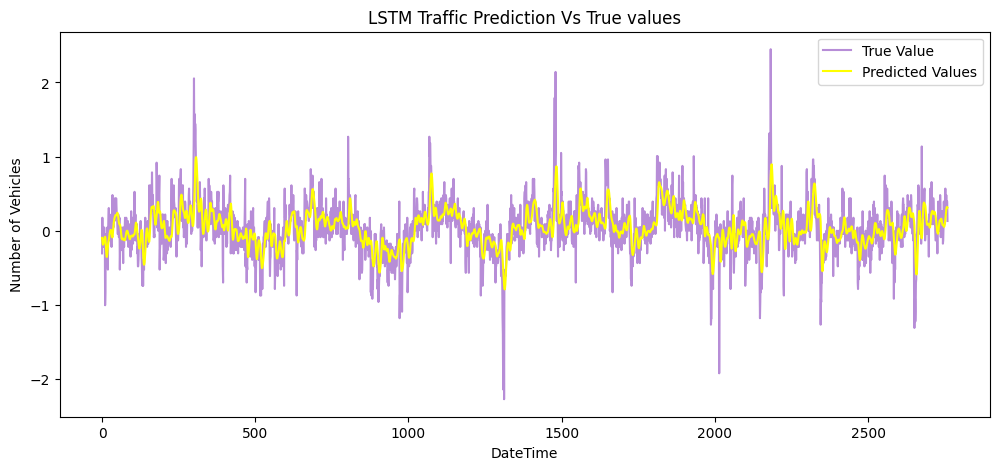

In [81]:
rmse_junction_1 = rmse_value(y_test_junction_1, pred_junction_1)  
print()
predictions_plot(y_test_junction_1, pred_junction_1, 0)

# JUNCTION 2

Now let's see the result of the second junction

In [77]:
pred_junction_2 = lstm_model(X_train_junction_2,y_train_junction_2,X_test_junction_2, y_test_junction_2)

Epoch 1/50
97/97 [==============================] - 22s 155ms/step - loss: 0.2738 - val_loss: 0.6574
Epoch 2/50
97/97 [==============================] - 15s 152ms/step - loss: 0.2576 - val_loss: 0.6042
Epoch 3/50
97/97 [==============================] - 15s 152ms/step - loss: 0.2366 - val_loss: 0.5192
Epoch 4/50
97/97 [==============================] - 15s 155ms/step - loss: 0.2202 - val_loss: 0.4795
Epoch 5/50
97/97 [==============================] - 16s 160ms/step - loss: 0.2175 - val_loss: 0.4656
Epoch 6/50
97/97 [==============================] - 16s 160ms/step - loss: 0.2140 - val_loss: 0.4528
Epoch 7/50
97/97 [==============================] - 15s 160ms/step - loss: 0.2127 - val_loss: 0.4497
Epoch 8/50
97/97 [==============================] - 16s 165ms/step - loss: 0.2114 - val_loss: 0.4456
Epoch 9/50
97/97 [==============================] - 16s 164ms/step - loss: 0.2098 - val_loss: 0.4367
Epoch 10/50
97/97 [==============================] - 16s 162ms/step - loss: 0.2073 - val_lo

The root mean squared error is 0.5482137605170947.



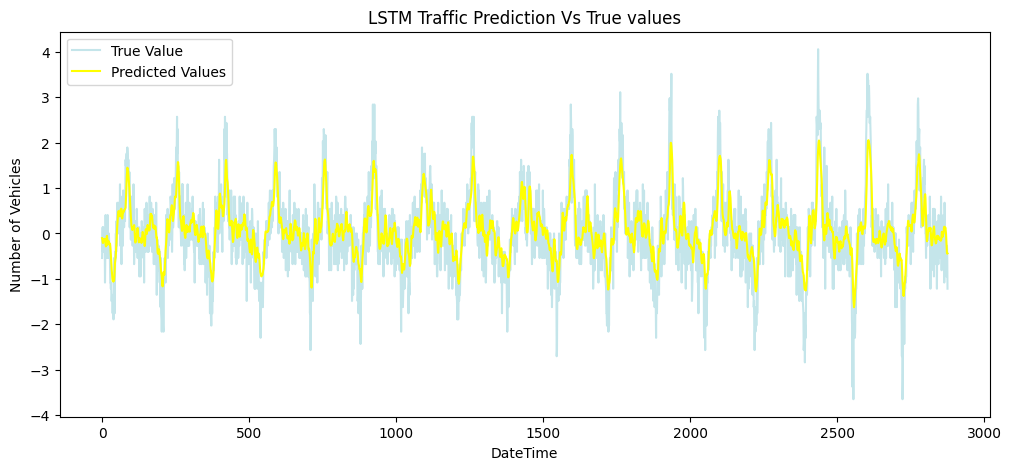

In [85]:
rmse_junction_2 = rmse_value(y_test_junction_2, pred_junction_2)  
print()
predictions_plot(y_test_junction_2, pred_junction_2, 1)

# JUNCTION 3

In [83]:
pred_junction_3 = lstm_model(X_train_junction_3,y_train_junction_3,X_test_junction_3, y_test_junction_3)

Epoch 1/50
98/98 [==============================] - 24s 166ms/step - loss: 0.2953 - val_loss: 0.3850
Epoch 2/50
98/98 [==============================] - 14s 141ms/step - loss: 0.2949 - val_loss: 0.3843
Epoch 3/50
98/98 [==============================] - 14s 143ms/step - loss: 0.2948 - val_loss: 0.3837
Epoch 4/50
98/98 [==============================] - 14s 142ms/step - loss: 0.2942 - val_loss: 0.3826
Epoch 5/50
98/98 [==============================] - 14s 139ms/step - loss: 0.2934 - val_loss: 0.3814
Epoch 6/50
98/98 [==============================] - 14s 142ms/step - loss: 0.2924 - val_loss: 0.3793
Epoch 7/50
98/98 [==============================] - 14s 145ms/step - loss: 0.2908 - val_loss: 0.3767
Epoch 8/50
98/98 [==============================] - 13s 135ms/step - loss: 0.2884 - val_loss: 0.3716
Epoch 9/50
98/98 [==============================] - 14s 141ms/step - loss: 0.2849 - val_loss: 0.3661
Epoch 10/50
98/98 [==============================] - 13s 138ms/step - loss: 0.2829 - val_lo

The root mean squared error is 0.5902314782273514.



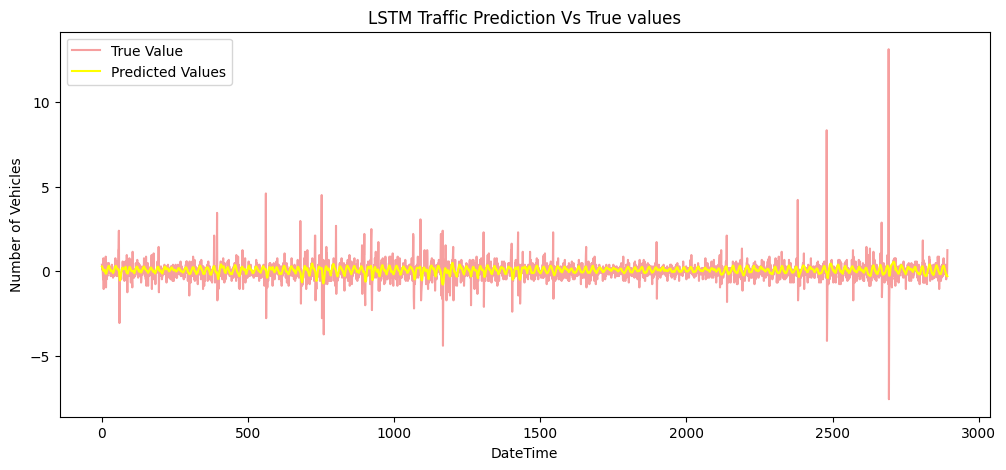

In [86]:
rmse_junction_3 = rmse_value(y_test_junction_3, pred_junction_3)
print()
predictions_plot(y_test_junction_3, pred_junction_3, 2)

# JUNCTION 4

In [87]:
pred_junction_4 = lstm_model(X_train_junction_4,y_train_junction_4,X_test_junction_4, y_test_junction_4)

Epoch 1/50
29/29 [==============================] - 14s 212ms/step - loss: 0.6792 - val_loss: 1.0153
Epoch 2/50
29/29 [==============================] - 4s 154ms/step - loss: 0.6787 - val_loss: 1.0150
Epoch 3/50
29/29 [==============================] - 4s 154ms/step - loss: 0.6794 - val_loss: 1.0149
Epoch 4/50
29/29 [==============================] - 4s 150ms/step - loss: 0.6793 - val_loss: 1.0146
Epoch 5/50
29/29 [==============================] - 4s 151ms/step - loss: 0.6786 - val_loss: 1.0144
Epoch 6/50
29/29 [==============================] - 4s 151ms/step - loss: 0.6789 - val_loss: 1.0142
Epoch 7/50
29/29 [==============================] - 5s 162ms/step - loss: 0.6788 - val_loss: 1.0140
Epoch 8/50
29/29 [==============================] - 4s 154ms/step - loss: 0.6787 - val_loss: 1.0138
Epoch 9/50
29/29 [==============================] - 4s 154ms/step - loss: 0.6791 - val_loss: 1.0135
Epoch 10/50
29/29 [==============================] - 4s 150ms/step - loss: 0.6782 - val_loss: 1.013

The root mean squared error is 0.9889352159381009.



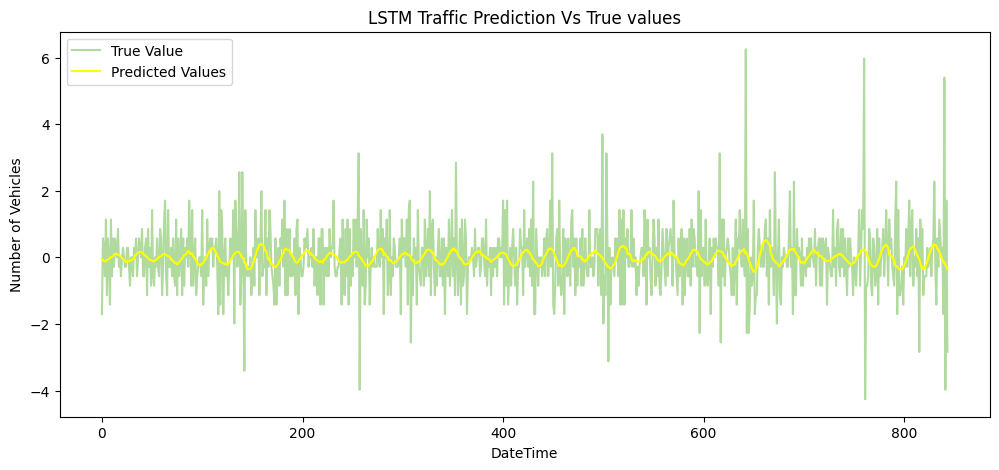

In [88]:
rmse_junction_4 = rmse_value(y_test_junction_4, pred_junction_4)
print()
predictions_plot(y_test_junction_4, pred_junction_4, 3)